In [2]:
import torchvision
import torch

/home/tnwei/miniconda3/envs/waternet/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


From torchvision docs, the base classes provided for custom datasets are DatasetFolder, ImageFolder, VisionDataset. No idea if they are suitable for im2im. I think I'll just use the base torch.utils.data.Dataset class and override `__len__` and `__getitem__`.

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

In [82]:
from pathlib import Path
import cv2
import os
import numpy as np

## Dataset class

In [4]:
class UIEBDataset(torch.utils.data.Dataset):
    """UIEBDataset."""

    def __init__(self, raw_dir, ref_dir, transform=None):
        raw_im_fns = sorted([i.name for i in Path(raw_dir).glob("*.png")])
        ref_im_fns = sorted([i.name for i in Path(ref_dir).glob("*.png")])
        
        assert set(raw_im_fns) == set(ref_im_fns)
        
        if transform is not None:
            self.transform = transform
        else:
            # TODO: resizing
            self.transform = None
            
        self.raw_dir = Path(raw_dir)
        self.ref_dir = Path(ref_dir)
        self.im_fns = raw_im_fns

    def __len__(self):
        return len(self.im_fns)

    def __getitem__(self, idx):
        raw_im = cv2.imread(os.fspath(self.raw_dir / self.im_fns[idx]))
        ref_im = cv2.imread(os.fspath(self.ref_dir / self.im_fns[idx]))

        raw_im = cv2.cvtColor(raw_im, cv2.COLOR_BGR2RGB)
        ref_im = cv2.cvtColor(ref_im, cv2.COLOR_BGR2RGB)
        
        raw_im = torch.FloatTensor(raw_im) / 255
        ref_im = torch.FloatTensor(ref_im) / 255
        
        if self.transform is not None:
            # TODO: Probably change to albumentations for this if have
            raw_im, ref_im = self.transform(raw_im, ref_im)
        
        return raw_im, ref_im

Trying this out using UIEB data. 

Downloaded the UIEB dataset from [https://li-chongyi.github.io/proj_benchmark.html](https://li-chongyi.github.io/proj_benchmark.html). Downloaded the raws and reference images, which are bundled in RAR files. Unzipped them as `raw-890` and `reference-890` folders containining PNG files in `data`.

In [5]:
dataset = UIEBDataset("../data/raw-890", "../data/reference-890")

In [6]:
len(dataset)

890

In [7]:
raw, ref = next(iter(dataset))

In [8]:
raw.shape, ref.shape

(torch.Size([450, 800, 3]), torch.Size([450, 800, 3]))

Hmm. Still need:
+ resizing
+ augmentations
+ OpenCV preprocessing in Torch

In [10]:
counter = 0
for raw, ref in iter(dataset):
    print(raw.shape)
    counter += 1
    if counter == 20:
        break

torch.Size([450, 800, 3])
torch.Size([360, 640, 3])
torch.Size([360, 640, 3])
torch.Size([363, 550, 3])
torch.Size([562, 750, 3])
torch.Size([750, 1000, 3])
torch.Size([366, 485, 3])
torch.Size([300, 440, 3])
torch.Size([370, 550, 3])
torch.Size([496, 700, 3])
torch.Size([360, 640, 3])
torch.Size([360, 640, 3])
torch.Size([850, 1200, 3])
torch.Size([803, 1280, 3])
torch.Size([360, 640, 3])
torch.Size([360, 640, 3])
torch.Size([248, 500, 3])
torch.Size([1450, 2000, 3])
torch.Size([360, 640, 3])
torch.Size([360, 640, 3])


Can see some of the common resolutions in there, but overall image sizes are somewhat irregular. The FCN part of the network shouldn't have any size requirements, but the perceptual loss layer does. Perceptual loss needs to be a multiple of 32.

In [15]:
import albumentations as A

In [58]:
transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5)
])

In [59]:
raw_arr = raw.numpy()
ref_arr = ref.numpy()

In [60]:
transformed = transforms(image=raw_arr, mask=ref_arr)

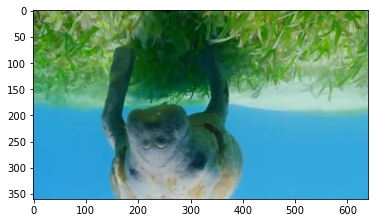

In [61]:
plt.imshow(transformed["image"])

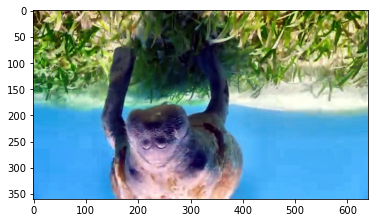

In [62]:
plt.imshow(transformed["mask"])

I like using albumentations because it accepts both the image and the label together. If I were to do this in torch, it would require joining both image and label together. Helps that in this case, I'm already using OpenCV. 

In [63]:
class UIEBDataset(torch.utils.data.Dataset):
    """UIEBDataset."""

    def __init__(self, raw_dir, ref_dir, legacy=True, transform=None):
        """
        legacy=True to replicate the paper's parameters
        """
        raw_im_fns = sorted([i.name for i in Path(raw_dir).glob("*.png")])
        ref_im_fns = sorted([i.name for i in Path(ref_dir).glob("*.png")])
        
        assert set(raw_im_fns) == set(ref_im_fns)
        
        if transform is not None:
            self.transform = transform
        else:
            self.transform = A.Compose([
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.RandomRotate90(p=0.5)
            ])
            
        self.legacy_transform = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5)
        ])
            
        self.raw_dir = Path(raw_dir)
        self.ref_dir = Path(ref_dir)
        self.im_fns = raw_im_fns
        self.legacy = legacy

    def __len__(self):
        return len(self.im_fns)

    def __getitem__(self, idx):
        # Load image
        raw_im = cv2.imread(os.fspath(self.raw_dir / self.im_fns[idx]))
        ref_im = cv2.imread(os.fspath(self.ref_dir / self.im_fns[idx]))
        
        if self.legacy is True:
            # Resize to 112x112
            raw_im = cv2.resize(raw_im, (112, 112))
            ref_im = cv2.resize(ref_im, (112, 112))
        else:
            # Resize image if required, VGG requires mult of 32
            im_w, im_h = raw_im.shape[0], raw_im.shape[1]
            vgg_im_w, vgg_im_h = int(im_w / 32) * 32, int(im_h / 32) * 32
            raw_im = cv2.resize(raw_im, (vgg_im_w, vgg_im_h))
            ref_im = cv2.resize(ref_im, (vgg_im_w, vgg_im_h))
        
        # Convert BGR to RGB for OpenCV
        raw_im = cv2.cvtColor(raw_im, cv2.COLOR_BGR2RGB)
        ref_im = cv2.cvtColor(ref_im, cv2.COLOR_BGR2RGB)
        
        # No legacy augmentations
        # Paper uses flipping and rotation transforms to obtain 7 augmented versions of data
        # Rotate by 90, 180, 270 degs, hflip, vflip? Not very clear
        # This is as close as it gets without having to go out of my way to reproduce exactly 7 augmented versions
        if self.legacy is True:
            transform = self.legacy_transform
        else:
            transform = self.transform
            
        if transform is not None:
            transformed = transform(image=raw_im, mask=ref_im)
            raw_im, ref_im = transformed["image"], transformed["mask"]
        else:
            pass
            
        # Scale to 0 - 1 float
        raw_im = torch.FloatTensor(raw_im) / 255
        ref_im = torch.FloatTensor(ref_im) / 255
        
        return raw_im, ref_im

Added above: resizing, augmentations

In [65]:
from data import transform as preprocess_transform

In [104]:
def arr2ten(arr):
    """Converts (N)HWC numpy array into torch Tensor:
    1. Divide by 255
    2. Rearrange dims: HWC -> CHW or NHWC -> NCHW
    """
    ten = torch.from_numpy(arr) / 255
    if len(ten.shape) == 3:
        # ten = rearrange(ten, "h w c -> 1 c h w")
        ten = torch.permute(ten, (2, 0, 1))

    elif len(ten.shape) == 4:
        # ten = rearrange(ten, "n h w c -> n c h w")
        ten = torch.permute(ten, (0, 3, 1, 2))
    return ten

In [105]:
class UIEBDataset(torch.utils.data.Dataset):
    """UIEBDataset."""

    def __init__(self, raw_dir, ref_dir, legacy=True, transform=None):
        """
        legacy=True to replicate the paper's parameters
        """
        raw_im_fns = sorted([i.name for i in Path(raw_dir).glob("*.png")])
        ref_im_fns = sorted([i.name for i in Path(ref_dir).glob("*.png")])
        
        assert set(raw_im_fns) == set(ref_im_fns)
        
        if transform is not None:
            self.transform = transform
        else:
            self.transform = A.Compose([
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.RandomRotate90(p=0.5)
            ])
            
        self.legacy_transform = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5)
        ])
            
        self.raw_dir = Path(raw_dir)
        self.ref_dir = Path(ref_dir)
        self.im_fns = raw_im_fns
        self.legacy = legacy

    def __len__(self):
        return len(self.im_fns)

    def __getitem__(self, idx):
        # Load image
        raw_im = cv2.imread(os.fspath(self.raw_dir / self.im_fns[idx]))
        ref_im = cv2.imread(os.fspath(self.ref_dir / self.im_fns[idx]))
        
        if self.legacy is True:
            # Resize to 112x112
            raw_im = cv2.resize(raw_im, (112, 112))
            ref_im = cv2.resize(ref_im, (112, 112))
        else:
            # Resize image if required, VGG requires mult of 32
            im_w, im_h = raw_im.shape[0], raw_im.shape[1]
            vgg_im_w, vgg_im_h = int(im_w / 32) * 32, int(im_h / 32) * 32
            raw_im = cv2.resize(raw_im, (vgg_im_w, vgg_im_h))
            ref_im = cv2.resize(ref_im, (vgg_im_w, vgg_im_h))
        
        # Convert BGR to RGB for OpenCV
        raw_im = cv2.cvtColor(raw_im, cv2.COLOR_BGR2RGB)
        ref_im = cv2.cvtColor(ref_im, cv2.COLOR_BGR2RGB)
        
        # No legacy augmentations
        # Paper uses flipping and rotation transforms to obtain 7 augmented versions of data
        # Rotate by 90, 180, 270 degs, hflip, vflip? Not very clear
        # This is as close as it gets without having to go out of my way to reproduce exactly 7 augmented versions
        if self.legacy is True:
            transform = self.legacy_transform
        else:
            transform = self.transform
            
        if transform is not None:
            transformed = transform(image=raw_im, mask=ref_im)
            raw_im, ref_im = transformed["image"], transformed["mask"]
        else:
            pass
            
        # Preprocessing transforms
        wb, gc, he = preprocess_transform(raw_im)

        # Scale to 0 - 1 float, convert to torch Tensor
        # Should be CHW tensors
        raw_ten = arr2ten(raw_im)
        wb_ten = arr2ten(wb)
        gc_ten = arr2ten(gc)
        he_ten = arr2ten(he)
        ref_ten = arr2ten(ref_im)
        
        # Was gonna make this a tuple until I realized how confused future me would be
        return {
            "raw": raw_ten, 
            "wb": wb_ten, 
            "gc": gc_ten, 
            "he": he_ten, 
            "ref": ref_ten,
        }

Added augmentations and dataset.

In [106]:
dataset = UIEBDataset("../data/raw-890", "../data/reference-890", legacy=True)

In [107]:
next_data = next(iter(dataset))

In [108]:
next_data["raw"].shape

torch.Size([3, 112, 112])

In [109]:
next_data["raw"]

tensor([[[0.0902, 0.0314, 0.0588,  ..., 0.0902, 0.0392, 0.0471],
         [0.1490, 0.0314, 0.0235,  ..., 0.0275, 0.0745, 0.0667],
         [0.0196, 0.0706, 0.0431,  ..., 0.0588, 0.0353, 0.0588],
         ...,
         [0.1255, 0.1294, 0.1294,  ..., 0.1255, 0.1412, 0.1294],
         [0.1294, 0.1333, 0.1294,  ..., 0.1333, 0.1373, 0.1373],
         [0.1294, 0.1333, 0.1333,  ..., 0.1333, 0.1373, 0.1373]],

        [[0.4784, 0.3373, 0.2667,  ..., 0.3686, 0.3294, 0.3451],
         [0.4824, 0.2784, 0.2353,  ..., 0.3176, 0.3333, 0.3098],
         [0.2784, 0.2784, 0.2706,  ..., 0.3569, 0.2745, 0.2549],
         ...,
         [0.7569, 0.7608, 0.7608,  ..., 0.7765, 0.7804, 0.7686],
         [0.7608, 0.7647, 0.7608,  ..., 0.7843, 0.7765, 0.7765],
         [0.7608, 0.7647, 0.7647,  ..., 0.7843, 0.7765, 0.7765]],

        [[0.5608, 0.3961, 0.3882,  ..., 0.4902, 0.4510, 0.4627],
         [0.5451, 0.3765, 0.3686,  ..., 0.4431, 0.4627, 0.4314],
         [0.3490, 0.4314, 0.4353,  ..., 0.4745, 0.4000, 0.

In [110]:
def ten2arr(ten):
    """Convert NCHW torch Tensor into NHWC numpy array:
    1. Multiply by 255, clip and change dtype to unsigned int
    2. Rearrange dims: CHW -> HWC or NCHW -> NHWC
    """
    arr = ten.cpu().detach().numpy()
    arr = np.clip(arr, 0, 1)
    arr = (arr * 255).astype(np.uint8)
    
    if len(arr.shape) == 3:
        # arr = rearrange(arr, "c h w -> h w c")
        arr = np.transpose(arr, (1, 2, 0))
    elif len(arr.shape) == 4:
        # arr = rearrange(arr, "n c h w -> n h w c")
        arr = np.transpose(arr, (0, 2, 3, 1))

    return arr

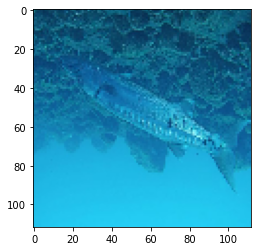

In [112]:
plt.imshow(ten2arr(next_data["raw"]))

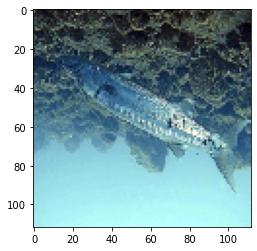

In [114]:
plt.imshow(ten2arr(next_data["ref"]))

Ok now to see how a dataloader batches the dict.

In [115]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=2)

In [116]:
a = next(iter(dataloader))

In [117]:
a.keys()

dict_keys(['raw', 'wb', 'gc', 'he', 'ref'])

Still a dict.

In [118]:
a["raw"].shape

torch.Size([2, 3, 112, 112])

Peeked under the hood for batching logic, a lot of good work went into it.